## Open Information Extraction
Open information extraction (open IE) refers to the extraction of relation tuples, typically binary relations, from plain text, such as (Mark Zuckerberg; founded; Facebook). The central difference from other information extraction is that the schema for these relations does not need to be specified in advance; typically the relation name is just the text linking two arguments.
- StanfordOpenIE (https://nlp.stanford.edu/software/openie.html) StanfordOpenIE is part of StanfordCoreNLP, which is built on top of PyTorch 1.0.0. 
 - Therefore, first install pytorch (https://pytorch.org/get-started/locally/), select your  os, package, language, cuda , then use the   command to install.
 - Install StanfordOpenIE using ``pip install stanford-openie``(https://pypi.org/project/stanford-openie/)
 - Install Java SE Development Kit 8 (https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html/)
 - Install graphviz : conda install python-graphviz
 - Unzip the stanford-corenlp-full-2018-10-05.zip to "C:\Users\UIC\stanfordnlp_resources"

In [1]:
import nltk
from nltk import pos_tag, word_tokenize, ne_chunk, Tree
from openie import StanfordOpenIE
from graphviz import Digraph

### Triple Extraction from text using ``StanfordOpenIE``

In [2]:
# Example code for using StanfordOpenIE in python
from openie import StanfordOpenIE

with StanfordOpenIE() as client:
    text = 'Barack Obama was the 44th president of the United States'
    print('Text: %s.' % text)
    # using the stanford open ie for using
    for triple in client.annotate(text):
        print('|-', triple)

Text: Barack Obama was the 44th president of the United States.
Starting server with command: java -Xmx8G -cp C:\Users\Lenovo\.stanfordnlp_resources\stanford-corenlp-4.1.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-22f8a4af4bcc4c16.props -preload openie
|- {'subject': 'Barack Obama', 'relation': 'was 44th president of', 'object': 'United States'}
|- {'subject': 'Barack Obama', 'relation': 'was president of', 'object': 'United States'}
|- {'subject': 'Barack Obama', 'relation': 'was', 'object': 'president'}
|- {'subject': 'Barack Obama', 'relation': 'was', 'object': '44th president'}


For each sentence, StanfordOpenIE will return several triples with high confidence scores. To further refine the results, we can perform filtering by some constraints:
- The subjet and object must be named entity from some predfined types
- The relation must be verb or verb phrases (chunk rule)

Come up with your own refinement strategy to get a better result.

In [3]:
def extract_triple(text):
    # your implementation
    print(text)
    
    # obtain chunks using ne_chunk()
    chunks = ne_chunk(pos_tag(word_tokenize(text)))
    # store all tokens of named entities(chunks) in a python list
#     print(chunks)
    terms_list = []
    for chunk in chunks:
        if type(chunk) == Tree:
            namelist=[]
            # append to token to the namelist
            for token,pos in chunk.leaves():
                namelist.append(token)
            name=" ".join(namelist)
            terms_list.append(name)
    
    # in order to get the right triple this time
    # you have to if the triple['subject'] and triple['object'] in 
    # the above named entities list or not
    print(terms_list)
    triples = []
    client =  StanfordOpenIE()
    # append the part into the triples
    for triple in client.annotate(text):
        if (triple['subject'] in terms_list) and (triple['object'] in terms_list):
            triples.append([triple['subject'], triple['relation'],  triple['object']])    
    return triples


tr = extract_triple(""" Barack Obama was the 44th president of the United States, and the first African American to serve in the office.
          On October 3, 1992,  Barack Obama married  Michelle Robinson at Trinity United Church in Chicago. """)
print("Extracted Triples:",tr)

 Barack Obama was the 44th president of the United States, and the first African American to serve in the office.
          On October 3, 1992,  Barack Obama married  Michelle Robinson at Trinity United Church in Chicago. 
['Barack', 'Obama', 'United States', 'African American', 'Barack Obama', 'Michelle Robinson', 'Trinity United Church', 'Chicago']
Starting server with command: java -Xmx8G -cp C:\Users\Lenovo\.stanfordnlp_resources\stanford-corenlp-4.1.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-56adb58ce0f3448a.props -preload openie
Extracted Triples: [['Barack Obama', 'was 44th president of', 'United States'], ['Barack Obama', 'was president of', 'United States'], ['Trinity United Church', 'is in', 'Chicago'], ['Barack Obama', 'married', 'Michelle Robinson'], ['Barack Obama', 'married Michelle Robinson at', 'Trinity United Church']]


### Construct the KB from Triples
Given the knowledge triples, we need to index all the entities and relations, i.e.,get the entity set and relation set, and represent each triple using entity id and relation id.

In [4]:
def KB(triples):
    ent=[]
    rels=[]
    # store named entities (subject and object) of triples to one list
    # store relation of triples to another list
    # refer to the above sample code
    for sub,rel,obj in triples:
        ent.append(sub)
        ent.append(obj)
        rels.append(rel)
    unent = set(ent)
    unent_rels = set(rels)
    
    #create a dictionary for this unique named entities
    # 创建index
    ind = range(len(unent))
    ind_rels = range(len(unent_rels))
    
    # create two dictionaries using zip function
    # one for named entities:
    # {0: 'Michelle Robinson', 1: 'United States', 2: 'Chicago', 3: 'Trinity United Church', 4: 'Barack Obama'}  
    # refer to the above sample code
    #生成以index为指向的字典
    id_en = dict(zip(ind, unent))
    
    # another one for relation:
    # {0: 'married', 1: 'married Michelle Robinson at', 2: 'was 44th president of', 
    # 3: 'was president of', 4: 'is in'} 
    id_re = dict(zip(ind_rels, unent_rels))
    
    
    # create a 2d list for triples from
    # [{'subject':'Barack Obama', 'relation':'was 44th president of', 'object':'United States'}, 
    # {'subject':'Barack Obama', 'relation':'was president of', 'object':'United States'},
    # {'subject':'Trinity United Church', 'relation':'is in', 'object':'Chicago'},
    # {'subject':'Barack Obama', 'relation':'married', 'object':'Michelle Robinson'},
    # {'subject':'Barack Obama', 'relation':'married Michelle Robinson at', 'object':'Trinity United Church'}]
    # to 
    # [[4, 2, 1], [4, 3, 1], [3, 4, 2], [4, 0, 0], [4, 1, 3]]
    id_en_inv = {value: key for key, value in id_en.items()}
    id_re_inv = {value: key for key, value in id_re.items()}
    triples_id = []
    for sub,rel,obj in triples:
        one_triples=[]
        one_triples.append(id_en_inv[sub])
        one_triples.append(id_re_inv[rel])
        one_triples.append(id_en_inv[obj])
        triples_id.append(one_triples)
    
    #return three newly created dictionaries for entities, relations and triples
    return id_en,id_re,triples_id

kb = KB(tr)
print("Entities:", kb[0], "\nRelations:",kb[1], "\nTriples:",kb[2])

Entities: {0: 'Chicago', 1: 'Michelle Robinson', 2: 'Barack Obama', 3: 'United States', 4: 'Trinity United Church'} 
Relations: {0: 'married', 1: 'married Michelle Robinson at', 2: 'is in', 3: 'was 44th president of', 4: 'was president of'} 
Triples: [[2, 3, 3], [2, 4, 3], [4, 2, 0], [2, 0, 1], [2, 1, 4]]


### Visualize the KB using ``graphviz``
- To render the graph, the dependency is a working installation of ``Graphviz`` (https://www.graphviz.org/download/).
- After installing Graphviz, make sure that its ``bin/`` subdirectory containing the layout commands for rendering graph descriptions (dot, circo, neato, etc.) is on your systems’ path: On the command-line, ``dot -V`` should print the version of your Graphiz installation.
- Refer to https://graphviz.readthedocs.io/en/stable/manual.html for the user guid of graphviz

In [5]:
def visualizeKB(kb_input):
    dot = Digraph(comment='KB-Demo')    
    
    #kb_input[0] is entity dict
    #kb_input[1] is the relation dict
    #kb_input[2] is the triple dict
    
    # please read graphviz doc on how to create a graph based on the kb info we have
    # before you start do this, please frist go through 
    #  https://graphviz.readthedocs.io/en/stable/manual.html
    # 
    #
    for key, value in kb_input[0].items():
        dot.node(str(key),str(value))
    for i in kb_input[2]:
        dot.edge(str(i[0]), str(i[2]), label=str(kb_input[1][i[1]]))
        
    return dot
dot = visualizeKB(kb)
print(dot.source)

// KB-Demo
digraph {
	0 [label=Chicago]
	1 [label="Michelle Robinson"]
	2 [label="Barack Obama"]
	3 [label="United States"]
	4 [label="Trinity United Church"]
	2 -> 3 [label="was 44th president of"]
	2 -> 3 [label="was president of"]
	4 -> 0 [label="is in"]
	2 -> 1 [label=married]
	2 -> 4 [label="married Michelle Robinson at"]
}



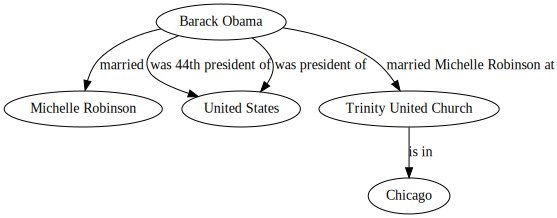

In [6]:
dot.render('kb-demo', view=True) 
dot